Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 178, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 178, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 51s 149ms/step - loss: 0.6926 - accuracy: 0.5329 - val_loss: 0.6918 - val_accuracy: 0.5804
Epoch 2/100
313/313 [=================

[0.3834255337715149, 0.8302000164985657]

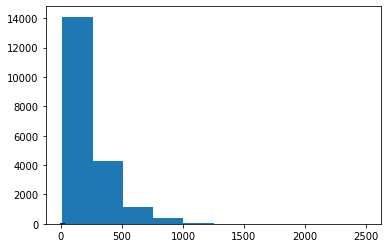

In [ ]:
# 기본 import
import pandas as pd # pd.DataFrame(변수)
import numpy as np # np.array(리스트)
import matplotlib.pyplot as plt  # plt.hist(변수), plt.plot(hy.history['loss'],color='r')      

# 케라스 데이터셋에서 imdb 문자열 파일 '로드' 
from keras.datasets import imdb
(X_data, y_data), (tt_x, tt_y) = imdb.load_data(num_words=500) # 500 : 등장빈도 500 위까지의 단어를 추출. 즉 500 가지 단어를 뽑는다. 1이 가장 높은 빈도
X_data.shape , y_data.shape, tt_x.shape, tt_y.shape

# 모양 확인 (2차원데이터, 한 묶음 당 다른 개수의 숫자들이 담겨있다, 한 묶음이 순환시퀀스로 들어갈 한 인풋 묶음이다) 
X_data, X_data.shape, len(X_data), len(X_data[0]), X_data[0][0], pd.DataFrame(X_data), np.unique(X_data, return_counts=True), np.unique(X_data[0], return_counts=True)
y_data, y_data.shape, len(y_data), y_data[0], pd.DataFrame(y_data), np.unique(y_data, return_counts=True)

# 트레인 테스트 '스플릿' (테스트셋 위에 있으니 벨리데이션셋)  
from sklearn.model_selection import train_test_split
t_x,v_x, t_y, v_y = train_test_split(X_data, y_data, test_size=0.2 , stratify = y_data , random_state=42) # stratify 스플릿을 해도 기존 아웃풋의 0 1 비율을 맞춰준다
t_x.shape,v_x.shape, t_y.shape, v_y.shape , tt_x.shape, tt_y.shape 

# 인풋 길이 '중앙값' 알아내기 : 인풋 길이를 담은 어레이를 만들고 중간값을 알아낸 후 패딩 맥스렌으로 일률적으로 인풋 길이를 맞춘다.
l = np.array( [len(x) for x in t_x ] ) # 각 인풋 묶음의 길이 값이 모였다
plt.hist(l) # 길이값의 편향을 확인하여 맥스렌 값을 결정, 대칭형태면 평균과 중앙값이 비슷하다. 편향이 심할수록 중앙값이 좋다, 실질적인 데이터는 편향이 심한 것이 많다
np.median(l) # 중앙값이 무조건 좋은 것은 아니다. 시각화를 통해 데이터를 적게 잃고 0 를 줄이는 값을 찾는 것이 좋다. 평균: np.mean(l), 최대: np.max(l) # median 미디언의 의미 : 최대최소의 중간값이 아니라 리스트에서 딱 중앙에 있는 걸 뜻한다. ex) 4,5,50,1000,2000 이면 중앙값은 50 이고 평균은 600 이다
 
# '패딩'으로 인풋 한 묶음의 길이를 일률적으로 맞춘다
from keras.preprocessing.sequence import pad_sequences
ck_t_x = pad_sequences(t_x, maxlen= 178) # 맥스렌에 위에서 알아낸 중간값을 넣는다. 그 값으로 한 묶음의 길이가 정해진다
ck_v_x = pad_sequences(v_x, maxlen= 178) # 맥스렌 생략시 가장 긴 묶음을 기준으로 적은 묶음에는 0을 억지로 넣어서 맞춰준다
ck_tt_x = pad_sequences(tt_x, maxlen= 178) # 긴 묶음에서 짧은 묶음으로 줄어드는 데이터는 데이터의 손실
ck_t_x.shape, ck_v_x.shape, ck_tt_x.shape, t_y.shape, v_y.shape, tt_y.shape

# '임베딩','신경망'만들기 : 임베딩은 자동 원핫의 일종
import tensorflow as tf
tf.keras.utils.set_random_seed(42) # 42로 고정되는 시드
tf.config.experimental.enable_op_determinism() # 이것도 고정 하는 것  
from keras import Sequential # 모델
from keras.layers import SimpleRNN, LSTM, GRU,   Dense, Embedding      
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
m = Sequential()  # 시퀀셜 모델 선언
m.add(Embedding(500,16,input_length=178 )) # 500위까지 뽑았으니까, 16차원(임의설정), 178 인풋 한묶음의 길이 (투카테원핫은 경우 500차원으로 느는데 임베딩은 차원이 적게 늘어서 좋다. 벡터화시키기 때문에 차원을 줄일 수 있다) # 투카테고리컬이 위에 왔다면 임베딩은 없고 아래 순환시퀀스에 인풋input_shape=(178,500) 을 넣어줘야한다. # 16 차원에 점하나 찍은 벡터화
m.add( LSTM(8,dropout=0.3, return_sequences=True) ) # 순환신경망은 인풋을 시퀀스로 받아야하기 때문에 연속으로 나열하려면 리턴시퀀스를 넣어야 한다. 
m.add( LSTM(8,dropout=0.3) ) # 은닉층을 늘린 것이다. # 순환신경망 # 8은 cell 셀 수 (뉴런수,임의의 값) # SimpleRNN 은 안좋다 LSTM, GRU 쓰자 RNN은 단기기억문제가크다
m.add( Dense( 1, activation='sigmoid' ) ) # 아웃풋1개, 출력층, 0은 부정적리뷰 1은 긍정적리뷰, # 이진분류(두개중하나선택) + 다중 레이블/라벨 분류(여러개중여러개선택) : 시그모이드 # 다중클래스분류(여러개중하나선택) : softmax # 회귀 : 액티베이션함수 없음      
m.summary() # LSTM 에 GRU   SimpleRNN 만 바꿔서 넣어주면 된다 # gru는 lstm이랑별차이없지만 간단한 데이터일 수록 gru가 좋음, 보통 LSTM이 좋음 # '액티베이션' 함수는 노드를 나오면서 weight값을 갱신하는 함수고 '옵티마이저'는 아웃풋을 로스펑션이 로스값을 계산한 후 백프로파게이션으로 초기weight를 갱신하기 위한 연산을 하는 함수다

# 학습방법, 얼리스탑, 체크포인트 지정
m.compile(optimizer = RMSprop(learning_rate=0.0001) , loss='binary_crossentropy'  , metrics=['accuracy'])  # 옵티마이저 알엠 기본값, 옵티마이저는 백프로파게이션값을 계산하는 함수다. 액티베이션은 인풋-아웃풋 과정에서 웨이트를 갱신하는 함수 # 로스펑션: 은 손실값을 계산하는 함수, 아웃풋기준 이진분류니까 binary, 다중분류면 sparse_categorical_crossentropy 다중분류인데 아웃풋을 원핫했으면 categorical_crossentropy : 아웃풋 원핫은 표현방법일 뿐 이진분류가 아니라 그대로 다중분류다 # mean_squared_error 회귀면 엠엣스이 이것만 기억 m.compile(loss='mse' metrics = ['mae'])  
es = EarlyStopping(patience= 4, restore_best_weights=True) # 손실이 떨어지지 않는 것을 4번 참는다, 베스트가중치를 기억한다.
ck = ModelCheckpoint ('m.h5') # 베스트가중치 체크포인트

# '학습' : 핏을 안해도 기존 m 에서도 초기weight 값에 의해 predict,evaluate계산이 된다. 여기서 m.fit 은 학습 시켜서 w를 갱신하는 것일 뿐이다. hy변수로 받는 것은 히스토리를 받았을 뿐 모델이 아니라 프레딕이 안된다
hy = m.fit(ck_t_x, t_y,  validation_data=(ck_v_x, v_y) ,  callbacks=[es,ck],  batch_size=64,  epochs=1  )  # 배치사이즈는 2의 배수로 #콜백사용시: 벨리데이션셋 권장 # 핏에 의한 가중치는 m 에 학습되어 있다 hy가 아니다. 딥러닝 모델은 여전히 m 이다. # 추가학습이 필요할 경우 그대로 아래칸에 복붙하면 애초에 에폭을 여러번 돌린 것과 같은 효과를 낼 수 있다.

# 로스 시각화
plt.plot(hy.history['loss'],color='r')
plt.plot(hy.history['val_loss'],color='b')

# 테스트셋 검증
m.predict(ck_tt_x) # x값을 받아서 y값을 예측
m.evaluate(ck_tt_x,tt_y)  # x,y 를 받아서 (로스, 정확도) 측정 

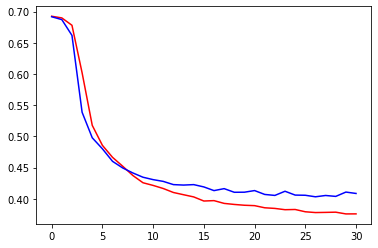

In [ ]:
plt.plot(hy.history['loss'],color='r')
plt.plot(hy.history['val_loss'],color='b')


In [ ]:
 
m.evaluate(ck_tt_x,tt_y)  # x,y 를 받아서 (로스, 정확도) 측정 

782/782 [==============================] - 18s 23ms/step - loss: 0.3834 - accuracy: 0.8302


[0.3834255337715149, 0.8302000164985657]